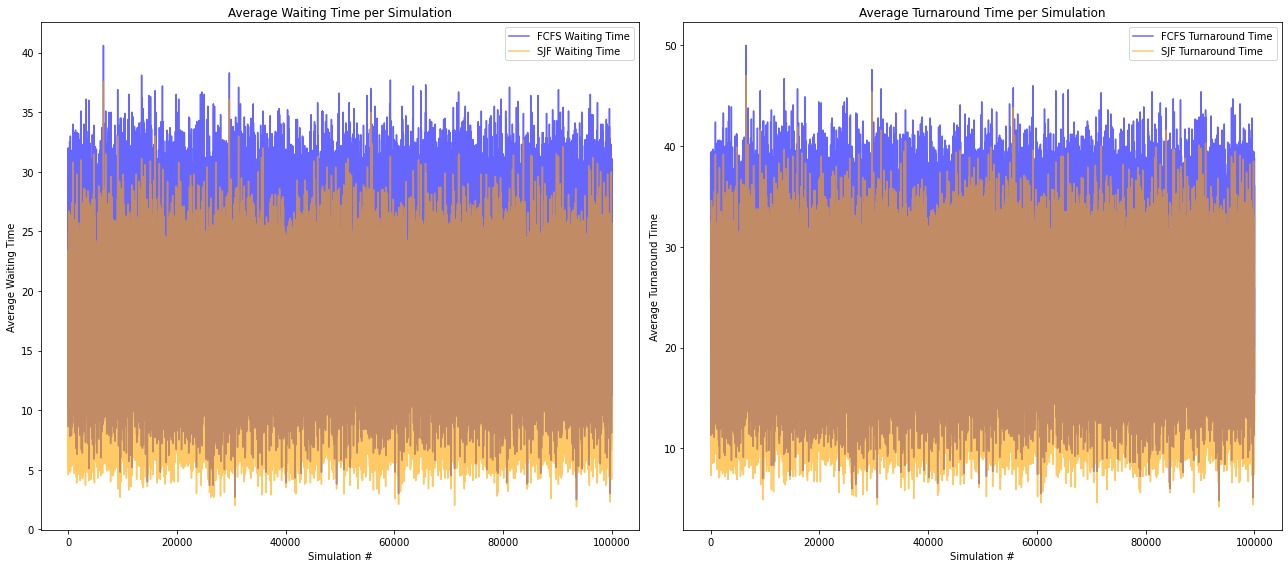

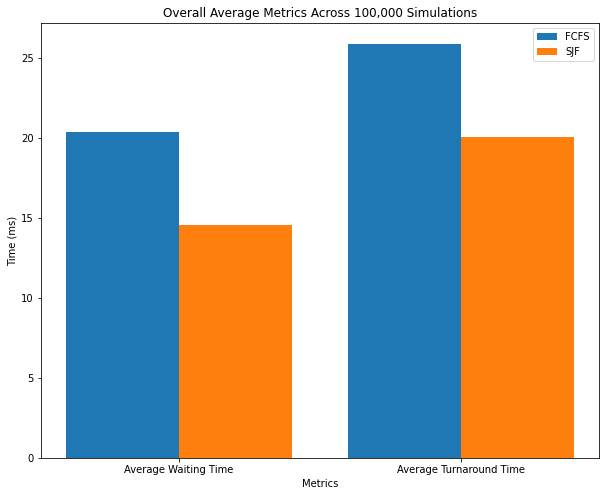

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define Process class
class Process:
    def __init__(self, pid, arrival_time, burst_time):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0

# FCFS Scheduling Function
def fcfs_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0

    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.burst_time + process.waiting_time

        current_time += process.burst_time

        total_waiting_time += process.waiting_time
        total_turnaround_time += process.turnaround_time

    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# SJF Scheduling Function
def sjf_scheduling(processes):
    processes.sort(key=lambda x: (x.arrival_time, x.burst_time))
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []

    while completed < n:
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)

        if ready_queue:
            ready_queue.sort(key=lambda x: x.burst_time)
            current_process = ready_queue.pop(0)

            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            current_process.waiting_time = current_time - current_process.arrival_time
            current_process.completion_time = current_time + current_process.burst_time
            current_process.turnaround_time = current_process.burst_time + current_process.waiting_time

            current_time += current_process.burst_time
            completed += 1

            total_waiting_time += current_process.waiting_time
            total_turnaround_time += current_process.turnaround_time
        else:
            current_time += 1

    return total_waiting_time / n, total_turnaround_time / n


# Generate random processes
def generate_random_processes(num_processes):
    return [Process(pid=i+1, arrival_time=random.randint(0, 10), burst_time=random.randint(1, 10)) for i in range(num_processes)]

# Run 100,000 simulations
def run_large_scale_simulation(num_simulations=100000, num_processes=10):
    fcfs_waiting_times = np.zeros(num_simulations)
    fcfs_turnaround_times = np.zeros(num_simulations)
    sjf_waiting_times = np.zeros(num_simulations)
    sjf_turnaround_times = np.zeros(num_simulations)

    for i in range(num_simulations):
        processes = generate_random_processes(num_processes)
        
        # Run FCFS
        fcfs_avg_waiting, fcfs_avg_turnaround = fcfs_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes])
        fcfs_waiting_times[i] = fcfs_avg_waiting
        fcfs_turnaround_times[i] = fcfs_avg_turnaround
        
        # Run SJF
        sjf_avg_waiting, sjf_avg_turnaround = sjf_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes])
        sjf_waiting_times[i] = sjf_avg_waiting
        sjf_turnaround_times[i] = sjf_avg_turnaround

    return fcfs_waiting_times, fcfs_turnaround_times, sjf_waiting_times, sjf_turnaround_times

# Visualization Function
def visualize_large_scale_results(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround):
    # Overall averages
    overall_fcfs_waiting = np.mean(fcfs_waiting)
    overall_fcfs_turnaround = np.mean(fcfs_turnaround)
    overall_sjf_waiting = np.mean(sjf_waiting)
    overall_sjf_turnaround = np.mean(sjf_turnaround)

    # Line charts for each simulation
    plt.figure(figsize=(18, 8))

    # Line chart for Waiting Time across simulations
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(fcfs_waiting) + 1), fcfs_waiting, label="FCFS Waiting Time", color="blue", alpha=0.6)
    plt.plot(range(1, len(sjf_waiting) + 1), sjf_waiting, label="SJF Waiting Time", color="orange", alpha=0.6)
    plt.xlabel("Simulation #")
    plt.ylabel("Average Waiting Time")
    plt.title("Average Waiting Time per Simulation")
    plt.legend()

    # Line chart for Turnaround Time across simulations
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(fcfs_turnaround) + 1), fcfs_turnaround, label="FCFS Turnaround Time", color="blue", alpha=0.6)
    plt.plot(range(1, len(sjf_turnaround) + 1), sjf_turnaround, label="SJF Turnaround Time", color="orange", alpha=0.6)
    plt.xlabel("Simulation #")
    plt.ylabel("Average Turnaround Time")
    plt.title("Average Turnaround Time per Simulation")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Column chart for overall average metrics
    labels = ["Average Waiting Time", "Average Turnaround Time"]
    fcfs_values = [overall_fcfs_waiting, overall_fcfs_turnaround]
    sjf_values = [overall_sjf_waiting, overall_sjf_turnaround]

    x = range(len(labels))

    plt.figure(figsize=(10, 8))
    plt.bar([p - 0.2 for p in x], fcfs_values, width=0.4, label="FCFS")
    plt.bar([p + 0.2 for p in x], sjf_values, width=0.4, label="SJF")
    plt.xlabel("Metrics")
    plt.ylabel("Time (ms)")
    plt.title("Overall Average Metrics Across 100,000 Simulations")
    plt.xticks(x, labels)
    plt.legend()
    plt.show()

# Execute large-scale simulation and visualize results
fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround = run_large_scale_simulation()
visualize_large_scale_results(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround)
